In [1]:
import os
import datetime as dt
import pandas as pd
import sqlite3 as lite

In [2]:
pd.set_option('display.width', 160)

In [3]:
%matplotlib inline
import matplotlib.pyplot as pyplt
pyplt.rcParams['figure.figsize'] = (24, 5)

In [4]:
now_dt = dt.datetime.now()
strdate = '20190712'
strdate2 = '2019-07-12'
# strdate = now_dt.strftime('%Y%m%d')
# strdate2 = now_dt.strftime('%Y-%m-%d')

In [5]:
conn = lite.connect('D:/Python/ZeroTrader/TAQ_NEW/TAQ_%s.db' % strdate)
sqltext = "SELECT * FROM TickData WHERE securitiestype = 'futures' AND feedsource = 'xing' AND datetime < '%s'" % (strdate2 + ' 17:00:00')
# sqltext = "SELECT * FROM FutOptTickData WHERE SecuritiesType = 'futures' AND FeedSource = 'cybos'"
df = pd.read_sql(sqltext, conn)
df = df[['shortcd', 'taq', 'datetime', 'buysell', 'lastprice', 'lastqty', 'askqty1', 'ask1', 'bid1', 'bidqty1']]

In [6]:
sqltext = """
SELECT 
DISTINCT(shortcd) 
FROM TickData 
WHERE 
SecuritiesType = 'futures' AND 
-- FeedSource = 'cybos' AND 
FeedSource = 'xing' AND 
shortcd LIKE '101%' 
ORDER BY shortcd
"""
df_big_shortcd = pd.read_sql(sqltext, conn)
sqltext = """
SELECT 
DISTINCT(shortcd) 
FROM TickData 
WHERE 
SecuritiesType = 'futures' AND 
-- FeedSource = 'cybos' AND 
FeedSource = 'xing' AND 
shortcd LIKE '105%' 
ORDER BY shortcd 
"""
df_mini_shortcd = pd.read_sql(sqltext, conn)
big_shortcd = df_big_shortcd['shortcd'].iloc[0]
mini_shortcd = df_mini_shortcd['shortcd'].iloc[0]
# big_shortcd = '101M6000'
# mini_shortcd = '105M5000'
print big_shortcd, mini_shortcd

101P9000 105P8000


In [7]:
# df['datetime'] = strdate2 + ' ' + df['Time']
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
# del df['datetime']
# del df['time']
df['mid'] = (df['bid1'].astype(float) + df['ask1'].astype(float)) * 0.5
df = df[df['mid'] > 0]

In [8]:
df_big = df[df['shortcd'] == big_shortcd]
df_mini = df[df['shortcd'] == mini_shortcd]
# df_big = df_big.loc[df_big.index.drop_duplicates()]
# df_mini = df_mini.loc[df_mini.index.drop_duplicates()]
df_big = df_big.reset_index(drop=True)
df_mini = df_mini.reset_index(drop=True)

# print df_big.head(20)
# print  df_mini.head(20)
print len(df_big), len(df_mini)

# df_total = pd.concat([df_big, df_mini], axis=1, sort=False)
# print df_total.head()

df_total = pd.merge(df_big, df_mini,how='outer', on='datetime')
df_total.index = df_total['datetime']
df_total = df_total.sort_index()
del df_total['datetime']
print df_total.head(20)

41821 32292
                        shortcd_x taq_x buysell_x  lastprice_x  lastqty_x  askqty1_x  ask1_x  bid1_x  bidqty1_x    mid_x shortcd_y taq_y buysell_y  \
datetime                                                                                                                                             
2019-07-12 09:14:23.101       NaN   NaN       NaN          NaN        NaN        NaN     NaN     NaN        NaN      NaN  105P8000     Q      None   
2019-07-12 09:14:23.539  101P9000     Q      None          NaN        NaN       83.0   272.1  272.05      121.0  272.075       NaN   NaN       NaN   
2019-07-12 09:14:23.882  101P9000     Q      None          NaN        NaN       88.0   272.1  272.05      116.0  272.075       NaN   NaN       NaN   
2019-07-12 09:14:23.929       NaN   NaN       NaN          NaN        NaN        NaN     NaN     NaN        NaN      NaN  105P8000     Q      None   
2019-07-12 09:14:24.398       NaN   NaN       NaN          NaN        NaN        NaN    

In [9]:
new_columns = ['Big_ShortCD', 'Big_TAQ', 'Big_BuySell', 'Big_LastPrice', 'Big_LastQty', 'Big_AskQty1', 'Big_Ask1', 'Big_Bid1', 'Big_BidQty1', 'Big_mid', 
				'Mini_ShortCD', 'Mini_TAQ', 'Mini_BuySell', 'Mini_LastPrice', 'Mini_LastQty', 'Mini_AskQty1', 'Mini_Ask1', 'Mini_Bid1', 'Mini_BidQty1', 'Mini_mid',]
new_columns = [item.lower() for item in new_columns]
df_total.columns = new_columns
df_total = df_total.ffill()
df_total['mid_diff'] = df_total['big_mid'] - df_total['mini_mid']
df_total_liquid = df_total[df_total['mini_ask1'].astype(float) - df_total['mini_bid1'].astype(float) <= 0.04]

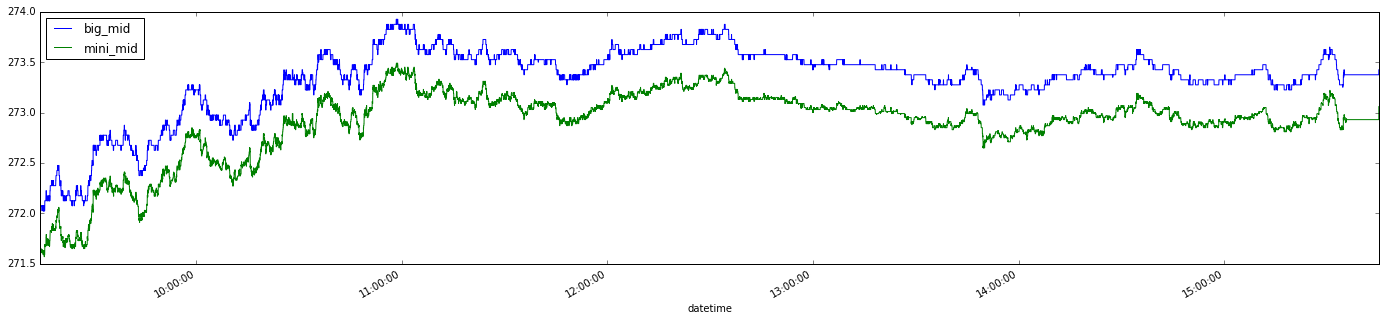

In [10]:
df_total[['big_mid', 'mini_mid']].plot()

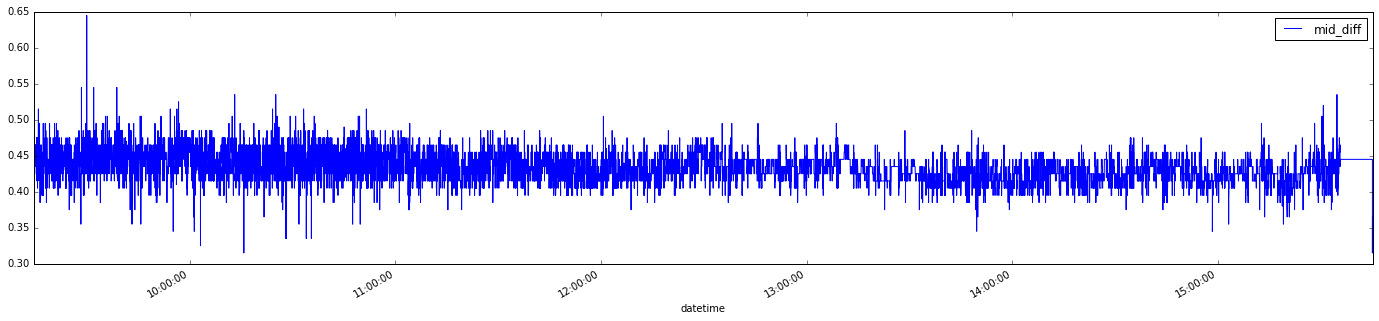

In [11]:
df_total[['mid_diff']].plot()

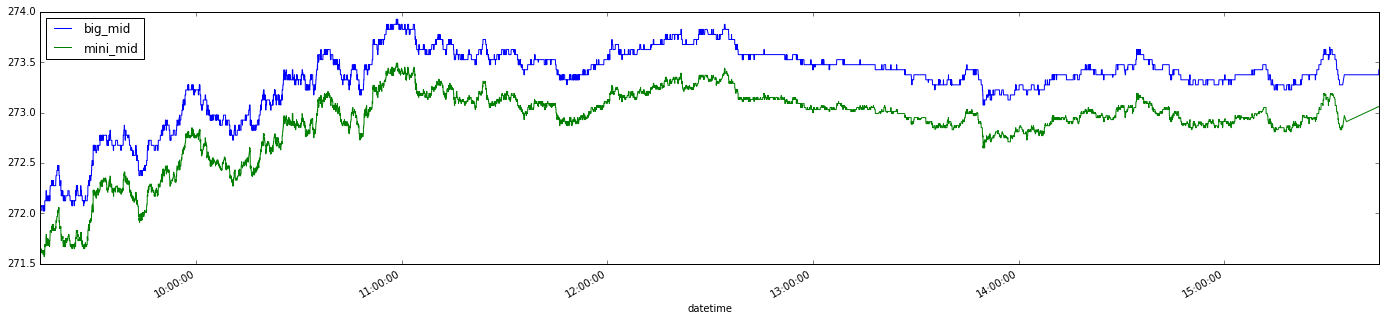

In [12]:
df_total_liquid[['big_mid', 'mini_mid']].plot()

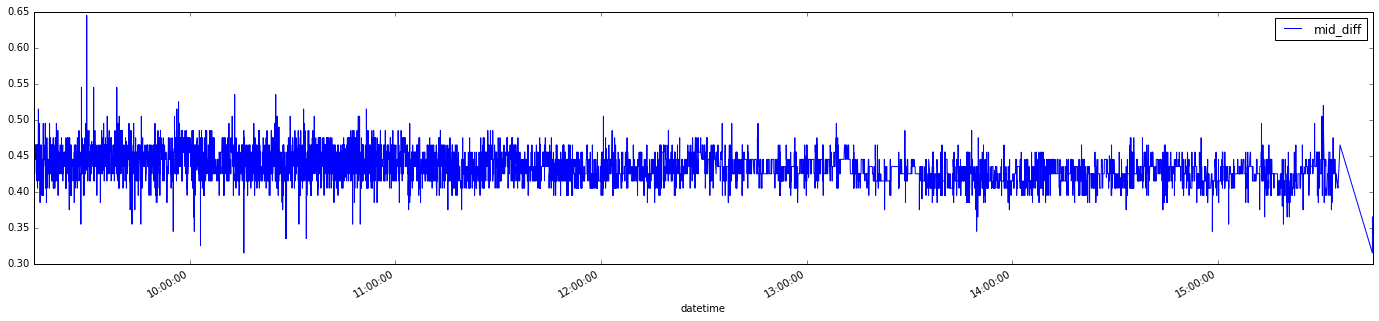

In [13]:
df_total_liquid[['mid_diff']].plot()

In [14]:
print df_total.iloc[1:][['big_mid', 'mini_mid', 'mid_diff']].describe()

            big_mid      mini_mid      mid_diff
count  71214.000000  71214.000000  71214.000000
mean     273.319540    272.885087      0.434453
std        0.371687      0.374274      0.017140
min      272.025000    271.570000      0.315000
25%      273.225000    272.810000      0.425000
50%      273.375000    272.960000      0.435000
75%      273.575000    273.120000      0.445000
max      273.925000    273.490000      0.645000


In [15]:
print df_total_liquid.iloc[1:][['big_mid', 'mini_mid', 'mid_diff']].describe()

            big_mid      mini_mid      mid_diff
count  59447.000000  59447.000000  59447.000000
mean     273.317226    272.882952      0.434274
std        0.375736      0.378371      0.017160
min      272.025000    271.570000      0.315000
25%      273.225000    272.810000      0.425000
50%      273.375000    272.970000      0.435000
75%      273.575000    273.120000      0.445000
max      273.925000    273.490000      0.645000
